# Project 2: Advanced Lane Finding

**The goals / steps of this project are the following:**

1. Camera Calibration
    - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Pipeline (test images)
    1. Apply a distortion correction to raw images.
    2. Use color transforms, gradients, etc., to create a thresholded binary image.
    3. Apply a perspective transform to rectify binary image ("birds-eye view").
    4. Detect lane pixels and fit to find the lane boundary.
    5. Determine the curvature of the lane and vehicle position with respect to center.
    6. Warp the detected lane boundaries back onto the original image.
3. Pipeline (video)
    - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
4. Discussion

In [1]:
import pickle
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# storge all parameters
params = {
    'mtx': None,        # matrix for undistortion
    'dist': None,       # distance for undistortion
    'M': None,          # Matrix for perspective transform
    'Minv': None        # Matrix for perspective transform back
    }

## Camera Calibration

**CRITERIA**
>- Briefly state `how you computed` the camera matrix and distortion coefficients. 
>- Provide an `example` of a distortion corrected calibration image.

**MEETS SPECIFICATIONS**
>- OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson).
>- The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

**What I have done:**

1. Frist of all, I have defined a function `Read_Test_Images(...)` to read all chessboard images from the "test_images" folder, then identified $n_x \times n_y$ points and returned their indices and coordinates (in pixels) through two variables `objpints` and `imgpoints`, respectively.
2. Next, I have obtained the calibration parameters, i.e., `mtx` and `dist` using `cv2.calibrateCamera` method which took the earlier calculated two variables `objpoints` and `imgpoints` as the inputs.
3. Lastly, i have undistorted one of the testing images using `cv2.undistort(...)` with the image, `mtx` and `dist` as the inputs, and printed out the results together with the original image side by side (the example is showed below).

In [3]:
#################################################
# intersting np.mgrid() function, to explore more
#################################################
nx=4
ny=2
objp = np.zeros((nx*ny, 3), np.float32)

np.mgrid[0:nx, 0:ny]

array([[[0, 0],
        [1, 1],
        [2, 2],
        [3, 3]],

       [[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]]])

In [4]:
np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1]])

In [5]:
def Read_Test_Images(folder_name, nx=9, ny=6, _print = False):
    
    '''
    Read images from the given folder, return points
    '''
    
    objpoints = []
    imgpoints = []
    imgnames = []
    imgs = []
    
    # learned from google ...
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # loop all images in the folder
    list_images = os.listdir(folder_name + '/')
    for img_name in list_images: 

        # read each image
        img = mpimg.imread(folder_name + '/' + img_name)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found
        if ret == True:
            objpoints.append(objp.copy())
            imgpoints.append(corners)
            imgnames.append(img_name)
            imgs.append(img)
            img_shape = img.shape[1::-1]
        else:
            if _print:
                print('cannot read:', img_name)
    if _print:
        print('total images:', len(objpoints))
    
    if _print:
        fig, axs = plt.subplots(len(objpoints)//2 + 1, 2, figsize=(10, 20))
        for i in range(len(objpoints)):
            corners = imgpoints[i]
            img = imgs[i]
            img_name = imgnames[i]

            cv2.drawChessboardCorners(img, (nx, ny), corners, True)
            row, col = divmod(i, 2)
            axs[row, col].imshow(img)
            axs[row, col].title.set_text(img_name)
        
    return objpoints, imgpoints, img_shape

In [6]:
# Calculate calibration matrix
objpoints, imgpoints, img_shape = Read_Test_Images('camera_cal', nx=9, ny=6, _print = False)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

print('objpoints len =', len(objpoints))
print('objpoints shape =', objpoints[0].shape)
print('imgpoints len =', len(imgpoints))
print('imgpoints shape =', imgpoints[0].shape)

#objpoints[10][:10]

objpoints len = 17
objpoints shape = (54, 3)
imgpoints len = 17
imgpoints shape = (54, 1, 2)


img shape (720, 1280, 3)


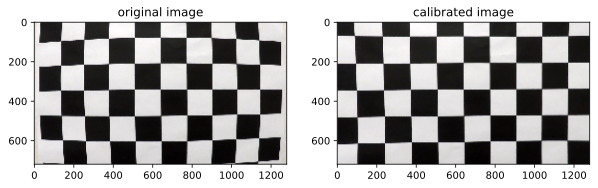

In [7]:
# testing on one image
img = mpimg.imread('camera_cal/calibration1.jpg')
print ('img shape', img.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(img)
axs[0].title.set_text('original image')

undistorted = cv2.undistort(img, mtx, dist, None, mtx) 
axs[1].imshow(undistorted)
axs[1].title.set_text('calibrated image')

fig.savefig('output_images/1_Camera_Calibration.jpg', dpi=150, bbox_inches='tight')

In [6]:
# store parameters
params['mtx'] = mtx
params['dist'] = dist
params

{'mtx': array([[1.15662906e+03, 0.00000000e+00, 6.69041438e+02],
        [0.00000000e+00, 1.15169194e+03, 3.88137239e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.23157149, -0.1200054 , -0.00118338,  0.00023305,  0.15641575]]),
 'M': None,
 'Minv': None}

## Pipeline (test images)

### distortion-correction

**CRITERIA**
>- Provide an example of a distortion-corrected image.

**MEETS SPECIFICATIONS**
>- Distortion correction that was calculated via camera calibration has been correctly applied to each image. An example of a distortion corrected image should be included in the writeup (or saved to a folder) and submitted with the project.

**Wha I have done:**
1. I have performed the distortion-correction using `cv2.undistort` on one of the testing images, an example is shown below.

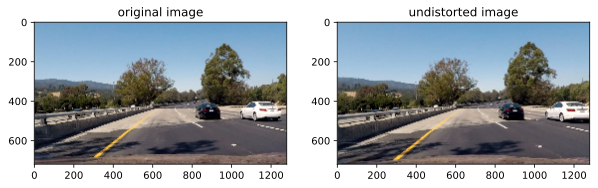

In [32]:
# read testing image
img = mpimg.imread('test_images/test4.jpg')

# undistort the image using 'mtx' and 'dist' obtained from the Camera Calibration
undistorted = cv2.undistort(img, params['mtx'], params['dist'], None, params['mtx']) 

# show images
fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(img)
axs[0].title.set_text('original image')
axs[1].imshow(undistorted)
axs[1].title.set_text('undistorted image')

fig.savefig('output_images/2_1_distortion_correction.jpg', dpi=150, bbox_inches='tight')

### Binary image

**CRITERIA**
>- Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

**MEETS SPECIFICATIONS**
>- A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. 
>- There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. 
>- Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

**What I have done:**
1. I have defined a function `binary_image` which returns a binary image combining the following two:
    - binary thresholding the result of applying the `Sobel operator in the x direction` on the original image.
    - binary thresholding the `S channel (HLS)` on the original image 
2. An example of the binary image is shown below.

**Future Works:**

<font color='red'>
    
- test different threshhold, any industry standard? to search online
- test different combination, e.g., y direction, x/y, HsV, etc

In [8]:
def Binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Note: img is the undistorted image
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, color_binary

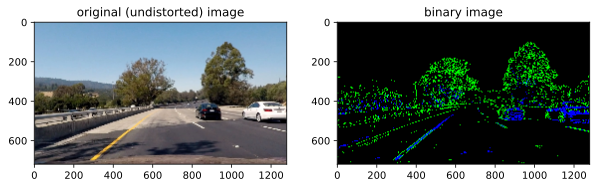

In [33]:
# read testing image
img = mpimg.imread('test_images/test4.jpg')

# undistort the image using 'mtx' and 'dist' obtained from the Camera Calibration
undistorted = cv2.undistort(img, params['mtx'], params['dist'], None, params['mtx']) 

# generate Binary image
gray_binary, color_binary = Binary_image(undistorted)

# show images
fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(undistorted)
axs[0].title.set_text('original (undistorted) image')
axs[1].imshow(color_binary)
axs[1].title.set_text('binary image')

fig.savefig('output_images/2_2_binary_image.jpg', dpi=150, bbox_inches='tight')

### Perspective transform

**CRITERIA**
>- Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

**MEETS SPECIFICATIONS**
>- OpenCV function or other method has been used to correctly rectify each image to a "birds-eye view". 
>- Transformed images should be included in the writeup (or saved to a folder) and submitted with the project.

**What I have done:**
1. First of all, I need to calculate the transform matrix M (and its inverse Minv). To make it possible, I have chosen one of the test images which shows straight lane lines in it and applied `cv2.undistort(...)` in order to get the source image `img_src`. 
2. Secondly, I have picked four points from both the source image and the destination image, respectively. 
3. Next, `cv2.getPerspectiveTransform(...)` was used to calculate the transform matrices M and Minv, respectively.
4. Lastly, an example was provided below for transforming the source image to a "birds-eye view" image, in which straight lane lines were drawn (in <font color='red'>red</font> solid lines) on both images

In [34]:
# read testing image
img = mpimg.imread('test_images/straight_lines1.jpg')

# undistort the image
img_src = cv2.undistort(img, params['mtx'], params['dist'], None, params['mtx']) 

# get image size
img_size = img.shape[1::-1]
# print(img_size)

In [35]:
# four points from the source image
src = np.float32(
        [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 9), img_size[1]],
        [(img_size[0] * 5 / 6) + 45, img_size[1]],
        [(img_size[0] / 2 + 61), img_size[1] / 2 + 100]])

# four points from the "birds-eye view" image
dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0] ])

# calculate the transform Matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

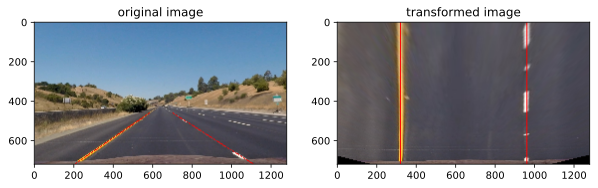

In [36]:
# warp  image to a "birds-eye view" using the transport Matrix
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

# draw lines in each image
color=(255,0,0)
thickness = 2
cv2.line(img_src, (src[0][0], src[0][1]), (src[1][0], src[1][1]), color, thickness)
cv2.line(img_src, (src[2][0], src[2][1]), (src[3][0], src[3][1]), color, thickness)
cv2.line(warped, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), color, thickness)
cv2.line(warped, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), color, thickness)

# show images
fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs[0].imshow(img_src)
axs[0].title.set_text('original image')
axs[1].imshow(warped)
axs[1].title.set_text('transformed image')

fig.savefig('output_images/2_3_Warp_Perspective.jpg', dpi=150, bbox_inches='tight')

In [37]:
# store parameters
params['M'] = M
params['Minv'] = Minv
params

{'mtx': array([[1.15662906e+03, 0.00000000e+00, 6.69041438e+02],
        [0.00000000e+00, 1.15169194e+03, 3.88137239e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.23157149, -0.1200054 , -0.00118338,  0.00023305,  0.15641575]]),
 'M': array([[-5.01668232e-01, -1.48924714e+00,  9.47175338e+02],
        [-2.04534048e-16, -1.96953011e+00,  9.05983850e+02],
        [-3.19948453e-19, -2.37669334e-03,  1.00000000e+00]]),
 'Minv': array([[ 1.85937500e-01, -7.71112434e-01,  5.22500000e+02],
        [ 1.18423789e-16, -5.07735286e-01,  4.60000000e+02],
        [ 2.20711141e-19, -1.20673111e-03,  1.00000000e+00]])}

###  Lane-line identification and fit with polynomial

**CRITERIA**
>- Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

**MEETS SPECIFICATIONS**
>- Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). 
>- Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

**What I have done:**
1. Firstly, I have chosen one of the test images with curved lane lines in it, and then applied pre-processing including distortion-correction, binary image and perspective transformation.
2. Then, I have defined a function `find_lane_pixels(...)` which uses sliding windows to find all lane pixels for both left and right lanes respectively. Three hyperparameters were defined as well namely `nwindows`, `margin` and `minpix` which indicate the number and width of the sliding windows as well as the minimum pixels found to re-center window.
3. Next, I have defined another function `fit_polynomial()` which obtains the polynomial coefficients for both left and right lane lines. Points of the fitted lane lines are also part of the returns for the next step use. 
4. Finally, I have applied the `fit_polynomial()` function to the image pre-processed earlier, and showed the resulting image with sliding windows, lane pixels identified and the fitted polynomial lines accordingly.

In [41]:
# read image
img = mpimg.imread('test_images/test4.jpg')
img_size = img.shape[1::-1]

# distortion-correction
undistorted = cv2.undistort(img, params['mtx'], params['dist'], None, params['mtx']) 

# Binary image
gray_binary, color_binary = Binary_image(undistorted)

# Perspective transform
binary_warped = cv2.warpPerspective(gray_binary, M, img_size, flags=cv2.INTER_LINEAR)

# plt.imshow(binary_warped, cmap='gray')

In [42]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50, plot = True):
   
    '''
    HYPERPARAMETERS: 
    
    nwindows - the number of sliding windows
    margin - the width of the windows +/- margin
    minpix - minimum number of pixels found to recenter window
    '''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint 

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        if plot: 
            cv2.rectangle(out_img,(win_xleft_low, win_y_low), 
                          (win_xleft_high, win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low, win_y_low),
                          (win_xright_high, win_y_high),(0,255,0), 2) 
        
        # Given Results: Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [43]:
def fit_polynomial(binary_warped, nwindows=9, margin=100, minpix=50, plot = True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix, plot)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # get left points
    left_pts = list(zip(left_fitx, ploty))
    left_pts = np.array(left_pts) #, np.int32)
    left_pts = left_pts.reshape((-1, 1, 2))
    
    # get right points
    right_pts = list(zip(right_fitx, ploty))
    right_pts = np.array(right_pts) #, np.int32)
    right_pts = right_pts.reshape((-1, 1, 2))

    # Plots the left and right polynomials on the lane lines
    if plot: 
        #plt.plot(left_fitx, ploty, color='yellow', linewidth=4)
        #plt.plot(right_fitx, ploty, color='yellow')
        cv2.polylines(out_img, np.array(left_pts,np.int32), isClosed=True,color=(255, 255, 0), thickness=2)
        cv2.polylines(out_img, np.array(right_pts,np.int32), isClosed=True,color=(255, 255, 0), thickness=2)

    return ploty, left_fit, right_fit, out_img, left_pts, right_pts

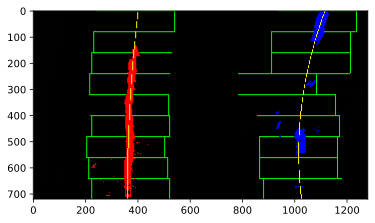

In [46]:
ploty, left_fit, right_fit, out_img, left_pts, right_pts = fit_polynomial(binary_warped, 
                                                                          nwindows=9, margin=150, minpix=50, plot = True)
fig = plt.imshow(out_img)

plt.savefig('output_images/2_4_fit_Polynomial.jpg', dpi=150, bbox_inches='tight')

### Radius of curvature and position of vehicle

**CRITERIA**
>- Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

**MEETS SPECIFICATIONS**
>- Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle.
>- For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

**What I have done:**

I have defined a function `measure_curvature_position(...)` which takes the polynominal coefficients and calcuate the curvatures of the two lane lines as well as the position of the car:
   - conversion has been done to translate pixels to real world meters for both $x$ and $y$ axes. 
   - position of the car was calculated by the difference between the middle point of the two lane line ends and the middle point of the image

In [18]:
def measure_curvature_position(ploty, img_size, left_fit, right_fit, my=30/720, mx=3.7/700):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
    ######### position
    
    y_max = img_size[1]
    x_left = left_fit[0]*(y_max**2) + left_fit[1]*y_max + left_fit[2]
    x_right = right_fit[0]*(y_max**2) + right_fit[1]*y_max + right_fit[2]
    
    x_mid = (x_left + x_right)/2
    x_delta = x_mid - img_size[1]
    pos = mx * x_delta
    
    ##### convert to real
    y_eval = np.max(ploty)
    ploty *= my
    
    left_fit_m = left_fit.copy()
    left_fit_m[0] *= mx / (my ** 2)
    left_fit_m[1] *= (mx / my)
    
    right_fit_m = right_fit.copy()
    right_fit_m[0] *= mx / (my ** 2)
    right_fit_m[1] *= (mx / my)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2, 3/2) \
                             / np.absolute(2*left_fit_m[0])
    right_curverad = np.power(1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2, 3/2) \
                             / np.absolute(2*right_fit_m[0])

    return left_curverad, right_curverad, pos

In [19]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, pos = measure_curvature_position(ploty, img_size, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')
print (f'Vehicle is {pos:.2f}m from center')

2268.9064971148796 m 2634.178103665419 m
Vehicle is -0.14m from center


### warped back image

**CRITERIA**
>- Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

**MEETS SPECIFICATIONS**
>- The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. 
>- This should demonstrate that the lane boundaries were correctly identified. 
>- An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

**What I have done:**
1. Firstly, I have defined a function `warped_back_points()` which calculates back the coordinates of the points in the "bird-eye view" to the original image view.
2. Then, I have used this function to convert points fitting for both left and right lane lines back to the original view, combined them together and drawn a polygon on to a black image.
3. Lastly, I have added the polygon image with the ordinal image using `cv2.addWeighted(...)` function. the output is shown below.

In [47]:
def warped_back_points(pts, Minv):
    
    dst_pts = pts.reshape((-1, 2))
    dst_pts = dst_pts.T
    dst_pts = np.vstack([dst_pts, np.ones(dst_pts.shape[1])])
    
    org_pts = np.dot(Minv, dst_pts)
    org_pts /= org_pts[2,:]  # this is very important !!!
    org_pts = org_pts[:2,:]
    org_pts = org_pts.T
    
    org_pts = np.array(org_pts, np.int32)
    org_pts = org_pts.reshape(((-1, 1, 2)))
    
    return org_pts

In [48]:
 def weighted_img(img, initial_img, α=0.9, β=0.1, γ=0.):
    """
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

(1440, 1, 2)


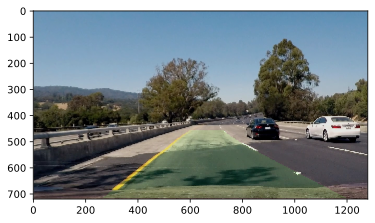

In [50]:
warped_back = cv2.warpPerspective(out_img, params['Minv'], img_size, flags=cv2.INTER_LINEAR)

org_left_pts = warped_back_points(left_pts, params['Minv'])
org_right_pts = warped_back_points(right_pts, params['Minv'])
all_org_pts = np.concatenate((org_left_pts, np.flip(org_right_pts, axis=0)))
print (all_org_pts.shape)

polygon_img = np.zeros((warped_back.shape[0], warped_back.shape[1], 3), dtype=np.uint8)
cv2.fillConvexPoly(polygon_img, all_org_pts, color=(0, 255, 0))

img_init = mpimg.imread('test_images/test4.jpg')
combined_img = weighted_img(polygon_img, img_init)

plt.imshow(combined_img)

plt.savefig('output_images/2_5_rapred_back.jpg', dpi=150, bbox_inches='tight')

### Put it togheter

1. This Section is to provide the full pipeline for the above steps
2. a test for all images in the test folder has been carried out

In [23]:
# define the pipeline (image)
def pipeline_Adv_Lane_Finding(img):
    
    img_size = img.shape[1::-1]
   
    # 1. distortion-correction
    undistorted = cv2.undistort(img, params['mtx'], params['dist'], None, params['mtx']) 
    
    # 2. Binary image
    gray_binary, color_binary = Binary_image(undistorted, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    # 3. Perspective transform
    warped = cv2.warpPerspective(gray_binary, params['M'], img_size, flags=cv2.INTER_LINEAR)
    
    # 4. fit with polynomial
    ploty, left_fit, right_fit, img_fit, left_pts, right_pts = fit_polynomial(warped, 
                                                                              nwindows=9, margin=130, minpix=50, 
                                                                              plot = False)
    # prev_margin=100
    
    # 5. calculate radius of curvature and position of vehicle
    left_curverad, right_curverad, pos = measure_curvature_position(ploty, img_size, left_fit, right_fit)
    
    # 6. warped back image
    org_left_pts = warped_back_points(left_pts, params['Minv'])
    org_right_pts = warped_back_points(right_pts, params['Minv'])
    all_org_pts = np.concatenate((org_left_pts, np.flip(org_right_pts, axis=0)))

    polygon_img = np.zeros((img_size[1], img_size[0], 3), dtype=np.uint8)
    cv2.fillConvexPoly(polygon_img, all_org_pts, color=(0, 255, 0))
    
    tmp = 'left'
    if pos >= 0: 
        tmp = 'right'
    pos = np.absolute(pos)
    
    txt1 = f'Radius of Curature = {int(left_curverad)}(m)'
    txt2 = f'Vehicle is {pos:.2f}m {tmp} of center'
    
    warped_back = weighted_img(polygon_img, undistorted)
    cv2.putText(warped_back, txt1, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(warped_back, txt2, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    # return results
    return warped_back

In [51]:
# to test all testing images
# loop and test all images in the "test_image/" folder

i = 0
list_images = os.listdir("test_images/")
fig, axs = plt.subplots(len(list_images), 2, figsize=(15, 30))

for img_name in list_images: 
    
    # read orginal image and show
    image = mpimg.imread('test_images/' + img_name)
    axs[i,0].imshow(image)
    axs[i,0].title.set_text(img_name + '[Input]')
    
    # run pipeline
    out_image = pipeline_Adv_Lane_Finding(image)
    
    # show result image
    axs[i,1].imshow(out_image)
    axs[i,1].title.set_text(img_name + ' [Output]')
    
    i += 1

fig.savefig('output_images/2_6_full_rapred_back.jpg', dpi=150, bbox_inches='tight')

## Pipeline (video)

**CRITERIA**
>- Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

**MEETS SPECIFICATIONS**
>- The image processing pipeline that was established to find the lane lines in images successfully processes the video. 
>- The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane.
>- The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. 
>- The output video should be linked to in the writeup and/or saved and submitted with the project.

**What I have done**
>- I have created the framework for outputting the video stream, taken the pipeline function defined earlier. 
>- the resulting video is linked in this doc for reference.

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline_Adv_Lane_Finding(image)
    
    return result

In [53]:
white_output = 'output_video/video_out.mp4'

In [30]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:03, 19.71it/s, now=None]

Moviepy - Building video otuput_video/video_out.mp4.
Moviepy - Writing video otuput_video/video_out.mp4



Moviepy - Done !
Moviepy - video ready otuput_video/video_out.mp4
CPU times: user 2min 45s, sys: 33.4 s, total: 3min 19s
Wall time: 2min 59s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Discussion

**CRITERIA**
>- Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

**MEETS SPECIFICATIONS**
>- Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.

**My inputs for discussion**
1. the binary image generated still has some noisy background points there, one potential solution might be using different gradient/color channels or threshold values to fine-turn it.
2. Another point is regarding the polynomial fitting for lane lines. I observed from the video that some of the curves might be overfitted with surrounding points. the noisy background points might contribute to this; However, I think the choosing of sizes the sliding window and min. points would contribute more. Further fine-turning of these hyperparameters might be one solution.